# Dados obtidos em www.simcosta.furg.br

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from datetime import datetime, timedelta

data_path = os.getcwd() + '/dados' # precisa limpar o cabecalho desses arquivos

In [2]:
def passa_data(data):
    return datetime.strptime(data, '%Y %m %d %H %M %S')

In [3]:
def trata_dado(path):
    dado = pd.read_csv(path)
    
    Ano = dado['YEAR'].apply(str)
    Mes = dado['MONTH'].apply(str)
    Dia = dado['DAY'].apply(str)
    Hora = dado['HOUR'].apply(str)
    Minuto = dado['MINUTE'].apply(str)
    Segundo = dado['SECOND'].apply(str)
    dado['DATA'] = (Ano + ' ' + Mes + ' ' + Dia + ' ' + Hora + ' ' + Minuto + ' ' + Segundo).apply(passa_data)
    dado = dado.set_index('DATA')
    del(dado['YEAR'])
    del(dado['MONTH'])
    del(dado['DAY'])
    del(dado['HOUR'])
    del(dado['MINUTE'])
    del(dado['SECOND'])
    
    return dado

In [4]:
def teste_serie_temporal(df, delta_time = 24*7):
    counter = 0
    falhas = []
    for i in range(len(df.index)):
        if df.index[i] > df.index[i-1] + timedelta(hours=delta_time):
            falhas.append((df.index[i-1], df.index[i]))
#             print('Inicio da falha temporal: ' + str(df.index[i-1]))
#             print('Fim da falha na serie temporal ' + str(df.index[i]))
            counter += 1
    print('Foram encontradas ' + str(counter) +' falhas na serie temporal.')
    return falhas

In [29]:
dado

,Hsig,EE,jump_flag,jump_crisrs,jump_crisis
DATA,,,,,
2016-07-15 00:25:00,0.06,2.980402,NaN,NaN,NaN
2016-07-15 01:25:00,0.08,2.980402,NaN,NaN,NaN
2016-07-15 02:25:00,0.05,2.980402,NaN,NaN,NaN
2016-07-15 03:25:00,0.09,2.980402,NaN,NaN,NaN
2016-07-15 04:25:00,0.08,2.980402,NaN,NaN,NaN
...,...,...,...,...,...
2021-08-31 13:51:40,NaN,2.980402,NaN,NaN,NaN
2021-08-31 14:21:40,NaN,2.980402,NaN,NaN,NaN
2021-08-31 14:51:40,NaN,2.980402,NaN,NaN,NaN


In [ ]:
def ajusta_dado(csv_path):
    dado = pd.read_csv(csv_path)
    Ano = dado['YEAR'].apply(str)
    Mes = dado['MONTH'].apply(str)
    Dia = dado['DAY'].apply(str)
    Hora = dado['HOUR'].apply(str)
    Minuto = dado['MINUTE'].apply(str)
    Segundo = dado['SECOND'].apply(str)
    
    dado['DATA'] = (Ano + ' ' + Mes + ' ' + Dia + ' ' + Hora + ' ' + Minuto + ' ' + Segundo).apply(passa_data)
    dado = dado.set_index('DATA')
    del(dado['YEAR'])
    del(dado['MONTH'])
    del(dado['DAY'])
    del(dado['HOUR'])
    del(dado['MINUTE'])
    del(dado['SECOND'])

In [5]:
# limiar de HS eh de 20m
# res HS = 0.01 -> acho que vou aproximar pra uma casa decimal so, fica mais facil de cortar dados espurios
# e talvez fique melhor discretizado

# se ficar mais de um dia sem dado, eu caracterizo como um GAP e "recorto" a serie temporal
# 24h - 1 ponto por h - 24 pontos

# WMO define um desvpad de 4* a media, entao vou usar esse cara aqui tbm
dado = pd.read_csv(data_path + '/' + os.listdir(data_path)[0])

Ano = dado['YEAR'].apply(str)
Mes = dado['MONTH'].apply(str)
Dia = dado['DAY'].apply(str)
Hora = dado['HOUR'].apply(str)
Minuto = dado['MINUTE'].apply(str)
Segundo = dado['SECOND'].apply(str)

dado['DATA'] = (Ano + ' ' + Mes + ' ' + Dia + ' ' + Hora + ' ' + Minuto + ' ' + Segundo).apply(passa_data)
dado = dado.set_index('DATA')
del(dado['YEAR'])
del(dado['MONTH'])
del(dado['DAY'])
del(dado['HOUR'])
del(dado['MINUTE'])
del(dado['SECOND'])

In [6]:
media = dado.mean()
desvpad = dado.std()
evento_extremo = media + 4*desvpad

In [7]:
evento_extremo_line = np.zeros(42881)
for i in range(len(evento_extremo_line)):
        evento_extremo_line[i] = evento_extremo

In [8]:
dado['EE'] = evento_extremo_line

In [9]:
############################################################

In [10]:
dados_nan = dado.isnull().where(dado['Hsig'].isnull() == True).dropna() # me da um DF com as datas de nan

In [11]:
# conta os buracos de Nan, provavelmente isso vai morrer
counter = 0
for i in range(len(dados_nan.index)):
    if dados_nan.index[i] == dados_nan.index[i-1] + timedelta(hours = 24*7):
        if counter == 48:
            print('Data inicial: ' + str(dados_nan.index[i]))
        counter += 1 # se o valor eh meia hora depois, comeco a contar
    else:
        if counter>=48:
            print('Data Final: ' + str(dados_nan.index[i]))
        counter = 0
    
        

In [12]:
col_jump_flag = np.empty(len(dado['Hsig']))
col_jump_flag[:] = np.nan


for i in range(len(dado['Hsig'])):
    if dado['Hsig'][i] >= evento_extremo[0] and abs(dado['Hsig'][i-1] - dado['Hsig'][i]) > desvpad['Hsig']: # a diferenca do valor extremo eh um desvpad
        col_jump_flag[i] = dado['Hsig'][i]
        #print(i)
        
dado['jump_flag'] = col_jump_flag

In [13]:
col_jump_flag = np.empty(len(dado['Hsig']))
col_jump_flag[:] = np.nan


for i in range(len(dado['Hsig'])):
    if dado['Hsig'][i] >= 0 and abs(dado['Hsig'][i-1] - dado['Hsig'][i]) > desvpad['Hsig']: # a diferenca do valor extremo eh um desvpad
        col_jump_flag[i] = dado['Hsig'][i]
        #print(i)
        
dado['jump_flag'] = col_jump_flag

In [24]:
# se for salto de 2 sigma, eh dado em crise

col_jump_crisis = np.empty(len(dado['Hsig']))
col_jump_crisis[:] = np.nan


for i in range(len(dado['Hsig'])):
    if dado['Hsig'][i] >= 0 and abs(dado['Hsig'][i-1] - dado['Hsig'][i]) > 2*desvpad['Hsig']: # a diferenca do valor extremo eh um desvpad
        col_jump_crisis[i] = dado['Hsig'][i]
        #print(i)
        
dado['jump_crisis'] = col_jump_crisis

In [14]:
##########################################################

Text(0.5, 1.0, 'Dados suspeitos marcados')

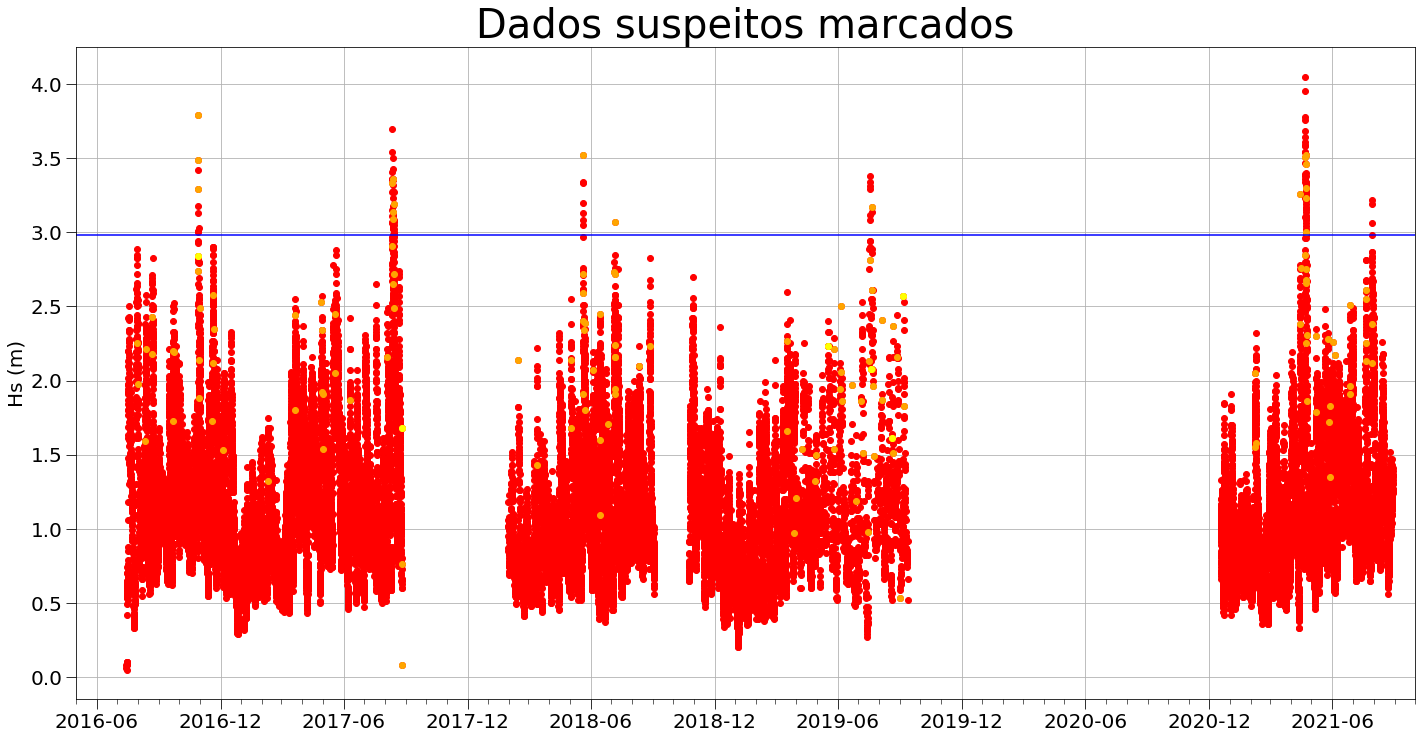

In [31]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(24,12))

ax = fig.add_subplot(111)
ax.plot(dado['Hsig'][:], marker = 'o', color = 'r', linestyle = 'none')
# ax.plot(dado['EE'][:], marker = '.', color = 'blue', linestyle = 'none')
ax.plot(dado['jump_flag'][:], marker = 'o', color = 'orange', linestyle = 'none')
ax.plot(dado['jump_crisis'][:], marker = 'o', color = 'yellow', linestyle = 'none')

plt.axhline(y=2.980402, color='blue', linestyle='-') # limite de evento extremo

ax.grid()
ax.set_ylabel('Hs (m)', fontsize = 20)

################################# data #######################

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


ax.tick_params(axis='both', which='major', labelsize=20, size=10)
ax.tick_params(axis='both', which='minor', size=5)

ax.set_xlim(datetime(2016,5,1), datetime(2021,10,1))



###########################################################################

plt.title('Dados suspeitos marcados', fontsize = 40)

In [16]:
# fazer histograma com essas alturas

/home/breno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


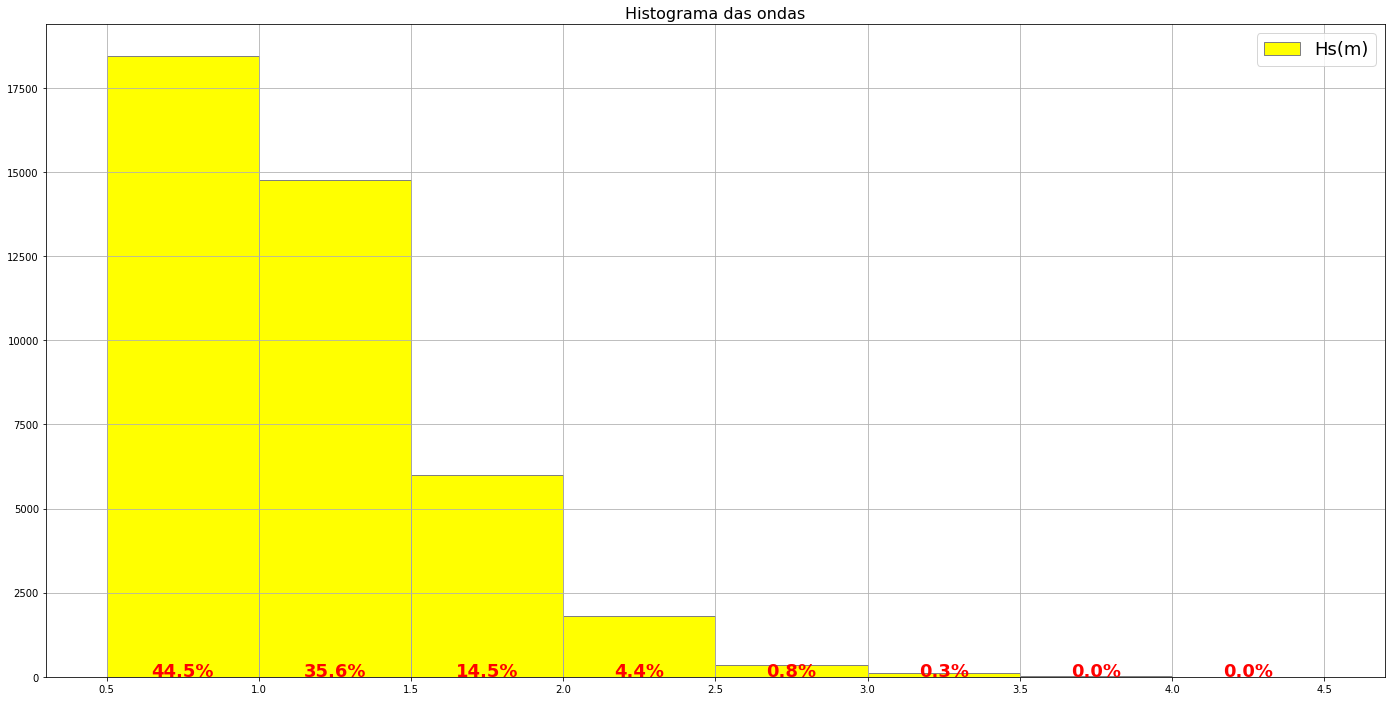

In [17]:
fig = plt.figure(figsize=(24,12))
plt.title('Histograma das ondas', fontsize=16)
ax = fig.add_subplot(111)
bins=np.arange(0.5, 5, 0.5)
counts, brings, patches = ax.hist(dado['Hsig'], bins= bins, facecolor='yellow', edgecolor='grey', label = 'Hs(m)')
ax.set_xticks(bins)
bin_centers=np.diff(bins) + bins[:-1] - 0.25
for count, x in zip(counts, bin_centers):
    percent = '%0.1f%%' % (100*float(count) / counts.sum())
    ax.annotate(percent, xy= (x,0), weight = 'bold', xycoords=('data', 'axes fraction'),xytext= (0,15),
                textcoords='offset points', va = 'top', ha='center', fontsize=18, color = 'red')
ax.legend(loc="upper right", fontsize=18)
plt.grid()

In [18]:
dado['Hsig'].kurtosis() # distribuicao que nao for gaussiana

1.6179205904547986

In [19]:
dado['Hsig'].skew() # tende a cair mais pro lado direito do que pro lado esquerdo na media

1.0915070312128754